# Genshin Impact Reviews Analysis
## 3. Sentiment Analysis & Classification (Part 1) - Trying Different Models
In this notebook, I will try different methods and techniques to achieve the aim of creating a model to do sentiment analysis and classification on the reviews.

Some of the techniques and models I will try include:
1. Existing Sentiment Analysis libraries (Such as textblob and vader)
2. Using Non-Neural Network Models
3. Using Neural Network Model (Specifically LSTM)

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from textblob import TextBlob

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import mark_negation

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(11)
tf.random.set_seed(11)

In [2]:
df = pd.read_pickle('data/final_df.p')
df.head()

,content,score,date,thumbsUp,source,text,length,update
0,"The graphics are gorgeous, the gameplay is inc...",5,2020-12-11 13:55:29,881.0,google_play_store,"[the, graphics, are, gorgeous, the, gameplay, ...",84,1.1.2
1,"If you love free world RPG, then this is it! T...",5,2020-12-16 18:10:47,48.0,google_play_store,"[if, you, love, free, world, rpg, then, this, ...",94,1.1.2
2,I absolutely love the game! No complaints besi...,5,2020-12-16 00:18:43,185.0,google_play_store,"[i, absolutely, love, the, game, no, complaint...",75,1.1.2
3,Great game. Regardless of ripoff issues and su...,4,2020-12-16 12:46:11,1.0,google_play_store,"[great, game, regardless, of, ripoff, issues, ...",88,1.1.2
4,Amazing graphics and gameplay although a lot o...,5,2020-12-10 22:51:08,186.0,google_play_store,"[amazing, graphics, and, gameplay, although, a...",86,1.1.2


In [3]:
df.shape

(88199, 8)

# Classification using Existing Sentiment Analysis Libraries

In [1]:
# define function that plots confusion matrix and provides the accuracy score of the model

def plot_confusion_matrix(y_test, pred, n_labels = 5):
    
    cm = confusion_matrix(y_test, pred)
    ticks = range(1, n_labels+1)

    plt.figure(figsize = (7, 5.5))
    sns.heatmap(cm, annot = True, fmt = '.5g', cmap = 'coolwarm', xticklabels = ticks, yticklabels = ticks)
    plt.title('Confusion Matrix', fontsize = 15)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print(f"Accuracy: {accuracy_score(y_test, pred):.4g}")

## Textblob
TextBlob uses a predefined sentiment lexicon to score each word. The scores of each words is then used to calculate a weighted average for the sentence to produce an overall sentence sentiment score. 

In [5]:
df['TB_polarity'] = df['content'].apply(lambda x: TextBlob(x).sentiment.polarity)
df.head(1)

,content,score,date,thumbsUp,source,text,length,update,TB_polarity
0,"The graphics are gorgeous, the gameplay is inc...",5,2020-12-11 13:55:29,881.0,google_play_store,"[the, graphics, are, gorgeous, the, gameplay, ...",84,1.1.2,0.270238
1,"If you love free world RPG, then this is it! T...",5,2020-12-16 18:10:47,48.0,google_play_store,"[if, you, love, free, world, rpg, then, this, ...",94,1.1.2,0.183889
2,I absolutely love the game! No complaints besi...,5,2020-12-16 00:18:43,185.0,google_play_store,"[i, absolutely, love, the, game, no, complaint...",75,1.1.2,0.034921
3,Great game. Regardless of ripoff issues and su...,4,2020-12-16 12:46:11,1.0,google_play_store,"[great, game, regardless, of, ripoff, issues, ...",88,1.1.2,0.073333
4,Amazing graphics and gameplay although a lot o...,5,2020-12-10 22:51:08,186.0,google_play_store,"[amazing, graphics, and, gameplay, although, a...",86,1.1.2,0.381629


To convert the polarity score to the ratings needed, I will use the pd.cut function from the pandas library to create 5 bins.

In [7]:
df['TB_pred'] = pd.cut(df['TB_polarity'],
                       bins=5,
                       labels=[1, 2, 3, 4, 5])

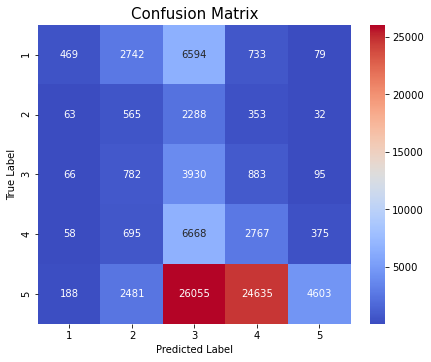

Accuracy: 0.1398


In [10]:
plot_confusion_matrix(df['score'], df['TB_pred'])

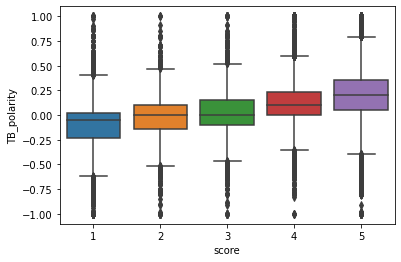

In [6]:
sns.boxplot(x="score", y="TB_polarity", data=df);

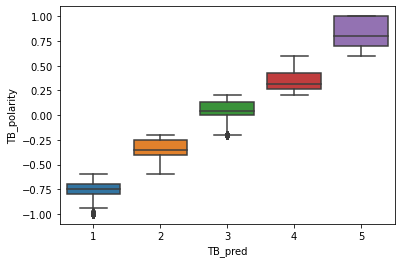

In [8]:
sns.boxplot(x="TB_pred", y="TB_polarity", data=df);

From the two plots, it can be seen that the polarity score for reviews from textblob are actually **very similar across the 5 ratings**. This is why the resulting accuracy after binning is extremely low.

## Vader
Similar to Textblob, Vader is another existing sentiment analysis library. It is part of the NLTK library.

Vader breaks down the sentiment scores for each sentence into a negative, neutral, positive and compound component. For this project, I will only be using the compound component as an overall sentiment score.

In [11]:
vader = SentimentIntensityAnalyzer()

vader.polarity_scores(df['content'][0])

{'neg': 0.061, 'neu': 0.579, 'pos': 0.36, 'compound': 0.9879}

In [12]:
VD_dict_list = df['content'].apply(lambda x: vader.polarity_scores(x))

df['VD_neg'] = [VD_dict['neg'] for VD_dict in VD_dict_list]
df['VD_neu'] = [VD_dict['neu'] for VD_dict in VD_dict_list]
df['VD_pos'] = [VD_dict['pos'] for VD_dict in VD_dict_list]
df['VD_compound'] = [VD_dict['compound'] for VD_dict in VD_dict_list]

df.head(1)

,content,score,date,thumbsUp,source,text,length,update,TB_polarity,TB_pred,VD_neg,VD_neu,VD_pos,VD_compound
0,"The graphics are gorgeous, the gameplay is inc...",5,2020-12-11 13:55:29,881.0,google_play_store,"[the, graphics, are, gorgeous, the, gameplay, ...",84,1.1.2,0.270238,4,0.061,0.579,0.360,0.9879
1,"If you love free world RPG, then this is it! T...",5,2020-12-16 18:10:47,48.0,google_play_store,"[if, you, love, free, world, rpg, then, this, ...",94,1.1.2,0.183889,3,0.049,0.766,0.185,0.9187
2,I absolutely love the game! No complaints besi...,5,2020-12-16 00:18:43,185.0,google_play_store,"[i, absolutely, love, the, game, no, complaint...",75,1.1.2,0.034921,3,0.156,0.663,0.181,0.6297
3,Great game. Regardless of ripoff issues and su...,4,2020-12-16 12:46:11,1.0,google_play_store,"[great, game, regardless, of, ripoff, issues, ...",88,1.1.2,0.073333,3,0.115,0.639,0.245,0.9274
4,Amazing graphics and gameplay although a lot o...,5,2020-12-10 22:51:08,186.0,google_play_store,"[amazing, graphics, and, gameplay, although, a...",86,1.1.2,0.381629,4,0.024,0.584,0.392,0.9908


In [14]:
df['VD_pred'] = pd.cut(df['VD_compound'],
                       bins=5,
                       labels=[1, 2, 3, 4, 5])

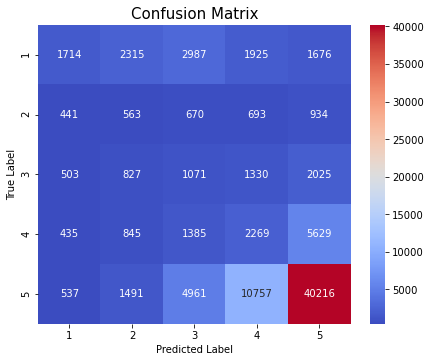

Accuracy: 0.5197


In [16]:
plot_confusion_matrix(df['score'], df['VD_pred'])

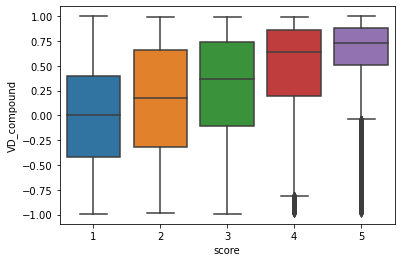

In [13]:
sns.boxplot(x="score", y="VD_compound", data=df);

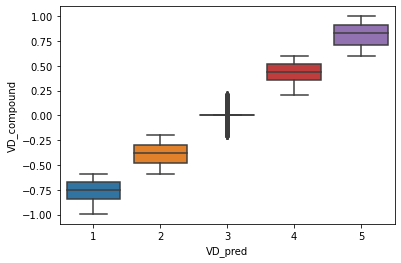

In [15]:
sns.boxplot(x="VD_pred", y="VD_compound", data=df);

Vader Sentiment Analysis is performs much better than Textblob. This can be seen from the **spread of compound score having a much bigger range** across the different ratings.

This also allows the binned result to have a much better accuracy compared to Textblob.

## Conclusion for Existing Sentiment Analysis Libraries
Vader performs much better than Textblob in providing more indicative scores for the sentiment of the reviews.

However, **both of these libraries are unable to distinguish the different ratings very well**. This can be seen from the low accuracy score and the overlap in the sentiment scores of different ratings (i.e. a rating of 1 and 5 can sentiment scores close to 1).

# Classification via Modeling (Non Neural Network)
The models I will try here are the models that are more suitable for NLP. These models are:
1. Logistic Regression
2. Multinominal Naive Bayes
3. Support Vector Machine

I will also try two vectorizers to compare their performance. These vectorizers are:
1. CountVectorizer
2. TfidfVectorizer

One thing to note is that, as there is very severe class imbalance, I will use the class_weight attribute whenever possible to increase the weightage of the minority classes to "correct" the class imbalance.

## Data Preparation
The models will be trained on a portion of the dataset to reduce the time needed for training these models.

The final model will be trained on the entire dataset.

In [17]:
model_df = df.sample(frac = 0.4, random_state = 11)

model_df['score'].value_counts(normalize = True, sort = False).plot(kind='bar');

In [19]:
X = model_df['content'].copy()
y = model_df['score'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 11, stratify = y)

**Negation Marking**

Negation marking is the use of putting a '_neg' identifier after negative words, such as "not fun". I will test if having this negation marking will improve the accuracy of the models.

In [20]:
model_df['content_neg_mark'] = model_df['text'].apply(lambda x: " ".join(mark_negation(x)))

In [21]:
X_neg = model_df['content_neg_mark'].copy()
y_neg = model_df['score'].copy()

X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(X_neg, y_neg, test_size = 0.2, random_state = 11, stratify = y)

### Define Functions

In [22]:
# define function to train the pipeline model and print the metrics
def test_pipeline(pipeline, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    
    learner = pipeline.fit(X_train, y_train)
    
    pred = learner.predict(X_test)
    
    plot_confusion_matrix(y_test, pred)

In [23]:
# define function to train the pipeline model on the dataset with negation marking and print the metrics
def test_neg_pipeline(pipeline, X_train = X_train_neg, y_train = y_train_neg, X_test = X_test_neg, y_test = y_test_neg):
    
    learner = pipeline.fit(X_train, y_train)
    
    pred = learner.predict(X_test)
    
    plot_confusion_matrix(y_test, pred)

In [24]:
# define function to run the pipeline model on both the normal and negation marked dataset
def test_both_pipeline(pipeline):
    
    print('========================')
    print('No Negation Marking')
    print('========================')
    test_pipeline(pipeline)
    print('\n\n')
    
    print('========================')
    print('With Negation Marking')
    print('========================')
    test_neg_pipeline(pipeline)


## Logistic Regression

No Negation Marking


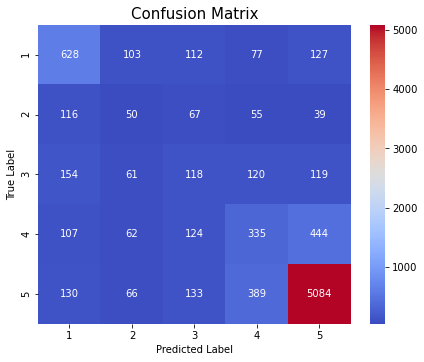

Accuracy: 0.7046



With Negation Marking


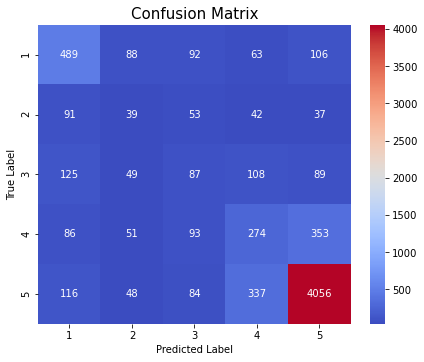

Accuracy: 0.7008


In [25]:
# using CountVectorizer
lr_pipeline = Pipeline([('vec', CountVectorizer()),
                        ('lrc', LogisticRegression(solver='liblinear', multi_class='auto', class_weight='balanced', random_state=11))])

test_both_pipeline(lr_pipeline)

No Negation Marking


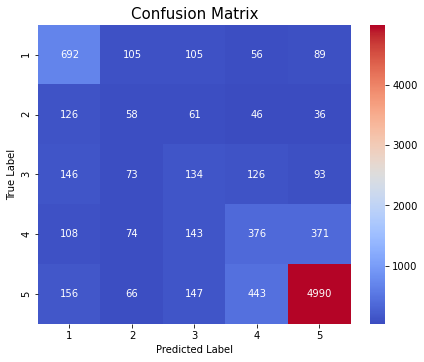

Accuracy: 0.7086



With Negation Marking


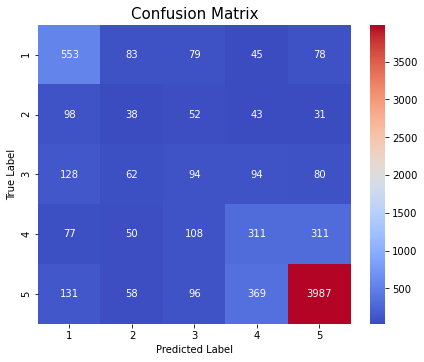

Accuracy: 0.7062


In [26]:
# using TfidfVectorizer
lr_pipeline_2 = Pipeline([('tvec', TfidfVectorizer()),
                          ('lrc', LogisticRegression(solver='liblinear', multi_class='auto', class_weight='balanced', random_state=11))])

test_both_pipeline(lr_pipeline_2)

### Conclusion for Logistic Regression
For Logistic Regression, **all four models performed similarly around 0.7**.

However, the models with TfidfVectorizer performs better than the CountVectorizer slightly and the model without negation marking performs better than the model with negation marking by a slight margin as well.

## Multinomial NB
Note that there is no class_weight attribute for Multinomial Naive Bayes.

No Negation Marking


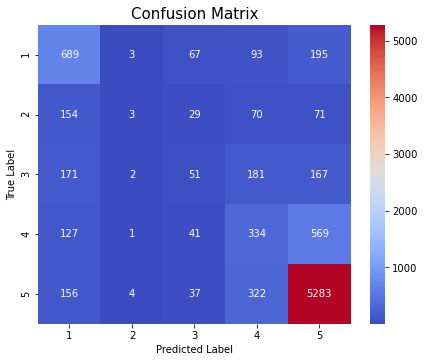

Accuracy: 0.7211



With Negation Marking


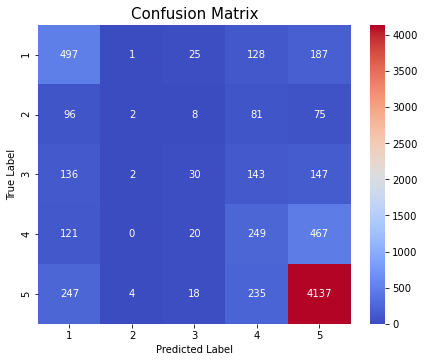

Accuracy: 0.6966


In [27]:
mnb_pipeline = Pipeline([('vec', CountVectorizer()),
                         ('mnb', MultinomialNB())])

test_both_pipeline(mnb_pipeline)

No Negation Marking


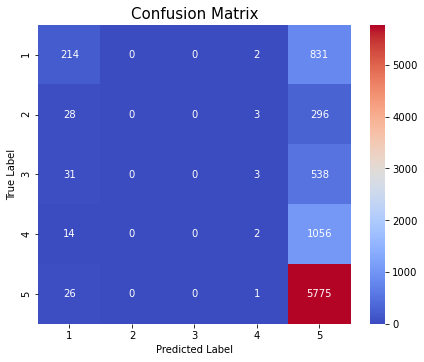

Accuracy: 0.6793



With Negation Marking


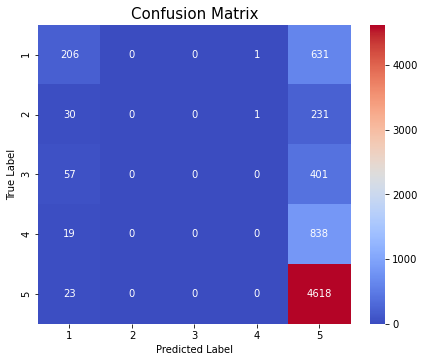

Accuracy: 0.6837


In [28]:
mnb_pipeline_2 = Pipeline([('tvec', TfidfVectorizer()),
                           ('mnb', MultinomialNB())])

test_both_pipeline(mnb_pipeline_2)

### Conclusion for Multinomial Naive Bayes
**MultinominalNB with CountVectorizer and no negation marking** obtained an accuracy of 72.11%, (better performance than Logistic Regression).

However, all multinominalNB models **performs badly when predicting reviews with fewer records** (ratings = 2 or 3). This could be because the class_weight cannot be set for this model.

Another observation is that **MultinominalNB does not perform well with TfidfVectorizer**. This should be because multinomial distribution requires integer feature counts, and hence, does not work well with the fractional counts from TfidfVectorizer.

## Support Vector Machine

No Negation Marking


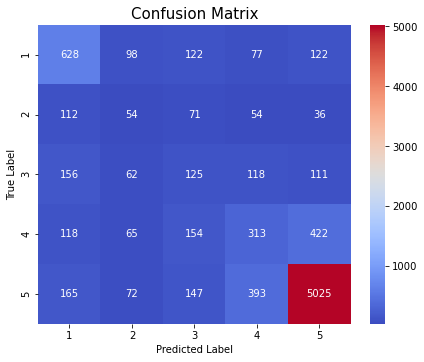

Accuracy: 0.6967



With Negation Marking


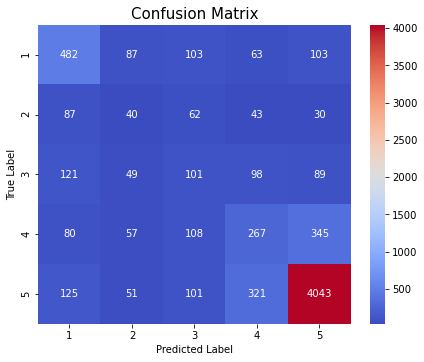

Accuracy: 0.6991


In [29]:
svm_pipeline = Pipeline([('vec', CountVectorizer()),
                         ('sgd', SGDClassifier(random_state=11,
                                               class_weight='balanced'))])

test_both_pipeline(svm_pipeline)

No Negation Marking


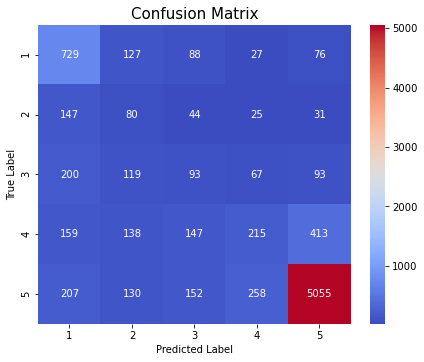

Accuracy: 0.6998



With Negation Marking


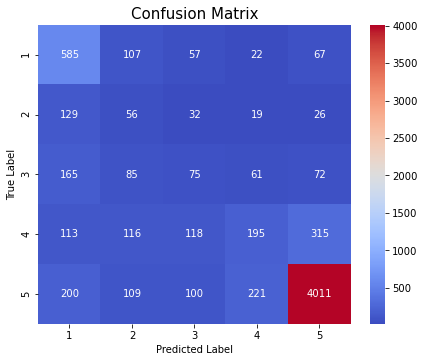

Accuracy: 0.6976


In [30]:
svm_pipeline_2 = Pipeline([('tvec', TfidfVectorizer()),
                           ('sgd', SGDClassifier(random_state=11,
                                                 class_weight='balanced'))])

test_both_pipeline(svm_pipeline_2)

### Conclusion for Support Vector Machine
All four models performed similarly with an accuracy of just below 70%.

Other than that, no other observable trends can be inferred from the use of different dataset and vectorizers.

## Conclusion on Modeling (Non Neural Network)

1. The use of negation marking does not significantly improve the resulting accuracy, instead, it decreases the accuracy slightly in most cases. Hence, **negation marking will not be used**.
2. For Logistic Regression and Support Vector Machine, TfidfVectorizer does slightly better than CountVectorizer.
3. For Multinomial Naive Bayes, TfidfVectorizer performs very poorly.

However, as all three models achieve roughly similar results of around 70%, I will try to use LSTM.

# Classification via Modeling (Neural Network)

## Data Preparation

Neural Network training will take longer, hence, I will only be doing the trials on a portion of the data.

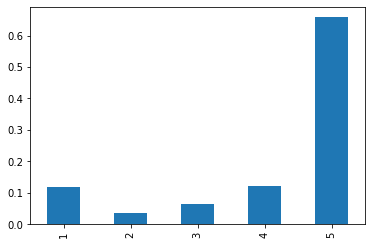

In [34]:
nn_df = model_df.copy()

nn_df['score'].value_counts(normalize=True).plot(kind='bar');

In [35]:
X = nn_df['content'].values
y = nn_df[['score']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 11, stratify = y)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((26460,), (26460, 1), (8820,), (8820, 1))

In [36]:
y_train.value_counts(normalize = True)

score
5        0.657785
4        0.121466
1        0.118745
3        0.064853
2        0.037150
dtype: float64

In [37]:
y_test.value_counts(normalize = True)

score
5        0.657823
4        0.121542
1        0.118707
3        0.064853
2        0.037075
dtype: float64

In [38]:
vocab_size = 7000

tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)

max_len = 125

train_padded_sequence = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = max_len)
test_padded_sequence = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen = max_len)

In [39]:
print(X_train[0])
print(train_padded_sequence[0])

It was soo amazing. The gane is so smooth
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    7   54  702   35    1 2139    5   14  255]


### Define Functions

In [31]:
# define function to find the class_weight (in ratio) for the different classes (ratings)
def find_class_weight(target_df):
    
    score_count = target_df.value_counts(sort=False)
    score_count_max = score_count.max()

    counter = 0
    score_class_weight = dict()

    for _, value in score_count.items():

        score_class_weight[counter] = score_count_max/value
        counter += 1

    return score_class_weight

In [32]:
# define function to plot the loss and metric (default as accuracy)
def plot_nn_history(history, metrics = 'accuracy'):
    
    fig, ax = plt.subplots(ncols = 2, figsize = (16, 5))

    ax[0].plot(history.history['loss'], label='Train Loss')
    ax[0].plot(history.history['val_loss'], label='Val Loss')
    ax[0].legend()

    ax[1].plot(history.history[metrics], label=f'Train {metrics.capitalize()}')
    ax[1].plot(history.history[f'val_{metrics}'], label=f'Val {metrics.capitalize()}')
    ax[1].legend()

    plt.show()

In [33]:
# define function to plot the confusion matrix using the training set
def nn_metrics(model, text_seq, y_test, n_labels):
    
    pred_array = model.predict(text_seq)

    pred = [np.where(array == array.max())[0][0]+1 for array in pred_array]
    
    plot_confusion_matrix(y_test, pred, n_labels)

## LSTM

In [40]:
enc = OneHotEncoder()
scores_cat = enc.fit_transform(y_train[['score']]).toarray()

classweight = find_class_weight(y_train[['score']])

In [41]:
classweight

{0: 5.53946530872056,
 1: 17.706002034587996,
 2: 10.142773892773892,
 3: 5.41537025513379,
 4: 1.0}

In [42]:
embedding_vector_length = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_len))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 125, 32)           224000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 125, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                16600     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 255       
Total params: 240,855
Trainable params: 240,855
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
earlystop_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

history = model.fit(train_padded_sequence, 
                    scores_cat, 
                    validation_split=0.2, 
                    epochs=10, 
                    batch_size=32, 
                    callbacks=[earlystop_callback], 
                    class_weight = classweight)

Epoch 1/10
662/662 [==============================] - 50s 76ms/step - loss: 4.7693 - accuracy: 0.5345 - val_loss: 1.0699 - val_accuracy: 0.6090
Epoch 2/10
662/662 [==============================] - 50s 76ms/step - loss: 4.2139 - accuracy: 0.6152 - val_loss: 1.0666 - val_accuracy: 0.5901
Epoch 3/10
662/662 [==============================] - 50s 76ms/step - loss: 3.9407 - accuracy: 0.6403 - val_loss: 0.9457 - val_accuracy: 0.6347
Epoch 4/10
662/662 [==============================] - 50s 76ms/step - loss: 3.7644 - accuracy: 0.6610 - val_loss: 0.9127 - val_accuracy: 0.6466
Epoch 5/10
662/662 [==============================] - 51s 76ms/step - loss: 3.5968 - accuracy: 0.6672 - val_loss: 0.8740 - val_accuracy: 0.6597
Epoch 6/10
662/662 [==============================] - 50s 76ms/step - loss: 3.4419 - accuracy: 0.6786 - val_loss: 0.9360 - val_accuracy: 0.6327
Epoch 7/10
662/662 [==============================] - 50s 76ms/step - loss: 3.3032 - accuracy: 0.6887 - val_loss: 0.8942 - val_accuracy:

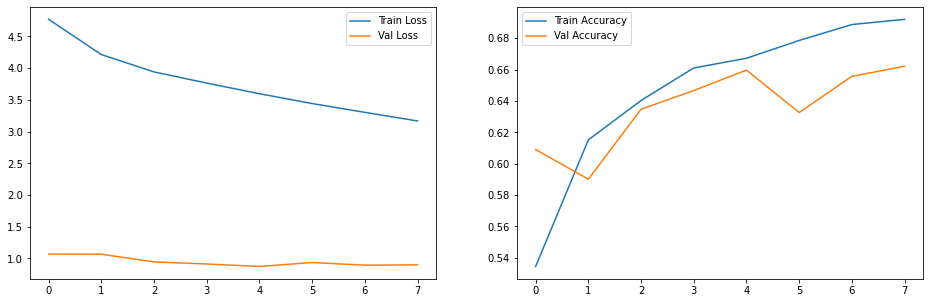

In [44]:
plot_nn_history(history)

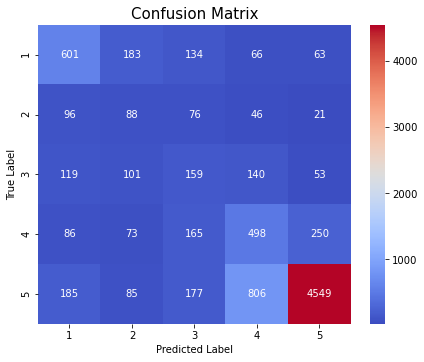

Accuracy: 0.6684


In [45]:
nn_metrics(model, test_padded_sequence, y_test['score'], 5)

Even with LSTM, the accuracy of models is very low. 

This should be largely due to:
1. **Highly imbalanced dataset**, where some classes (rating = 2 and 3) have much fewer records than the majority class (rating = 5).
2. **Insignificant difference between some of the ratings** (i.e. there might not be huge difference between reviews with ratings of 1 and 2). 

In order to proceed, I will try to reduce the imbalance by combining some classes, to reduce the 5 classes to:
1. **3 Classes** - Positive, Neutral and Negative class
2. **2 Classes** - Positive and Negative

This will still allow us to achieve the aim of creating a model that will be able to sort through the feedback into positive and negative feedbacks. 

## LSTM (3 Classes)

In [46]:
y_train = y_train.copy()
y_test = y_test.copy()

In [47]:
def positive_neutral_negative(score):
    if score < 3:
        return 1
    if score ==  3:
        return 2
    if score > 3:
        return 3
    
y_train['pnn'] = y_train['score'].apply(lambda x: positive_neutral_negative(x))
y_test['pnn'] = y_test['score'].apply(lambda x: positive_neutral_negative(x))

enc = OneHotEncoder()
scores_cat = enc.fit_transform(y_train[['pnn']]).toarray()

classweight = find_class_weight(y_train[['pnn']])

In [48]:
embedding_vector_length = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_len))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

earlystop_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

history = model.fit(train_padded_sequence, scores_cat, validation_split=0.2, 
                    epochs=10, batch_size=32, callbacks=[earlystop_callback], class_weight = classweight)

Epoch 1/10
662/662 [==============================] - 50s 76ms/step - loss: 2.1118 - accuracy: 0.6833 - val_loss: 0.6930 - val_accuracy: 0.7300
Epoch 2/10
662/662 [==============================] - 50s 76ms/step - loss: 1.7912 - accuracy: 0.7422 - val_loss: 0.6923 - val_accuracy: 0.7133
Epoch 3/10
662/662 [==============================] - 51s 76ms/step - loss: 1.6316 - accuracy: 0.7657 - val_loss: 0.5535 - val_accuracy: 0.7766
Epoch 4/10
662/662 [==============================] - 51s 77ms/step - loss: 1.5031 - accuracy: 0.7800 - val_loss: 0.6393 - val_accuracy: 0.7256
Epoch 5/10
662/662 [==============================] - 50s 76ms/step - loss: 1.4142 - accuracy: 0.7964 - val_loss: 0.5452 - val_accuracy: 0.7800
Epoch 6/10
662/662 [==============================] - 51s 77ms/step - loss: 1.3282 - accuracy: 0.8020 - val_loss: 0.5331 - val_accuracy: 0.7834
Epoch 7/10
662/662 [==============================] - 51s 77ms/step - loss: 1.2560 - accuracy: 0.8111 - val_loss: 0.5808 - val_accuracy:

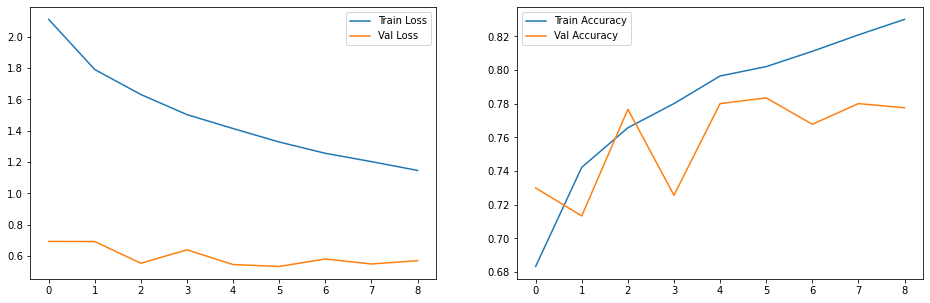

In [49]:
plot_nn_history(history)

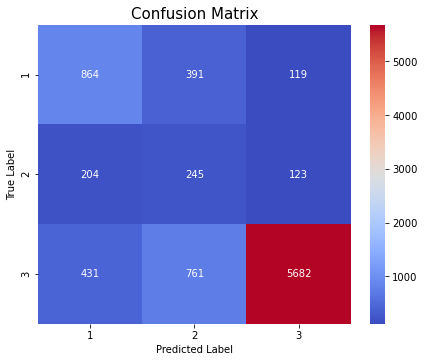

Accuracy: 0.77


In [50]:
nn_metrics(model, test_padded_sequence, y_test['pnn'], 3)

There is an increase in accuracy, but it is still not ideal. I will try LSTM with 2 classes.

## LSTM (2 Classes)

### Reviews with Rating of 3 = Negative

In [51]:
def positive_negative(score):
    if score <= 3:
        return 1
    if score > 3:
        return 2
    
y_train['pn'] = y_train['score'].apply(lambda x: positive_negative(x))
y_test['pn'] = y_test['score'].apply(lambda x: positive_negative(x))

enc = OneHotEncoder()
scores_cat = enc.fit_transform(y_train[['pn']]).toarray()

classweight = find_class_weight(y_train[['pn']])

In [52]:
embedding_vector_length = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_len))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

earlystop_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

history = model.fit(train_padded_sequence, scores_cat, validation_split=0.2, 
                    epochs=10, batch_size=32, callbacks=[earlystop_callback], class_weight = classweight)

Epoch 1/10
662/662 [==============================] - 51s 77ms/step - loss: 0.7329 - accuracy: 0.7657 - val_loss: 0.3839 - val_accuracy: 0.8326
Epoch 2/10
662/662 [==============================] - 50s 76ms/step - loss: 0.5407 - accuracy: 0.8448 - val_loss: 0.3912 - val_accuracy: 0.8439
Epoch 3/10
662/662 [==============================] - 50s 76ms/step - loss: 0.4755 - accuracy: 0.8611 - val_loss: 0.3467 - val_accuracy: 0.8519
Epoch 4/10
662/662 [==============================] - 50s 76ms/step - loss: 0.4436 - accuracy: 0.8734 - val_loss: 0.3641 - val_accuracy: 0.8424
Epoch 5/10
662/662 [==============================] - 50s 76ms/step - loss: 0.4040 - accuracy: 0.8856 - val_loss: 0.3450 - val_accuracy: 0.8549
Epoch 6/10
662/662 [==============================] - 50s 76ms/step - loss: 0.3866 - accuracy: 0.8892 - val_loss: 0.3426 - val_accuracy: 0.8573
Epoch 7/10
662/662 [==============================] - 53s 80ms/step - loss: 0.3667 - accuracy: 0.8937 - val_loss: 0.3835 - val_accuracy:

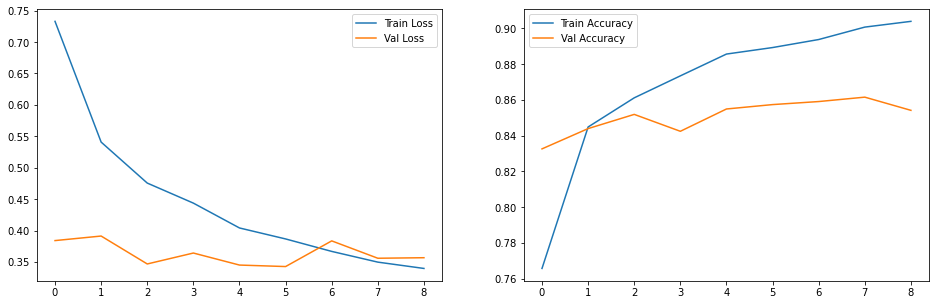

In [53]:
plot_nn_history(history)

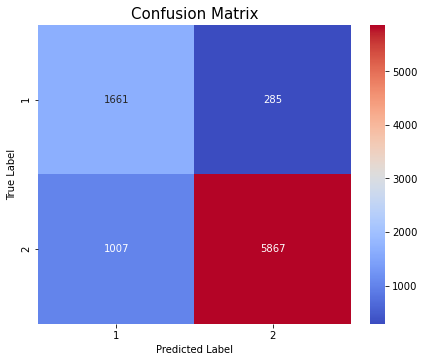

Accuracy: 0.8535


In [54]:
nn_metrics(model, test_padded_sequence, y_test['pn'], 2)

### Reviews with Rating of 3 = Positive

In [55]:
def positive_negative_2(score):
    if score < 3:
        return 1
    if score >= 3:
        return 2
    
y_train['pn_2'] = y_train['score'].apply(lambda x: positive_negative(x))
y_test['pn_2'] = y_test['score'].apply(lambda x: positive_negative(x))

enc = OneHotEncoder()
scores_cat = enc.fit_transform(y_train[['pn_2']]).toarray()

classweight = find_class_weight(y_train[['pn_2']])

In [56]:
embedding_vector_length = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_len))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

earlystop_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

history = model.fit(train_padded_sequence, scores_cat, validation_split=0.2, 
                    epochs=10, batch_size=32, callbacks=[earlystop_callback], class_weight = classweight)

Epoch 1/10
662/662 [==============================] - 50s 76ms/step - loss: 0.7377 - accuracy: 0.7663 - val_loss: 0.4314 - val_accuracy: 0.8118
Epoch 2/10
662/662 [==============================] - 50s 76ms/step - loss: 0.5339 - accuracy: 0.8443 - val_loss: 0.4356 - val_accuracy: 0.8112
Epoch 3/10
662/662 [==============================] - 50s 75ms/step - loss: 0.4804 - accuracy: 0.8598 - val_loss: 0.3389 - val_accuracy: 0.8526
Epoch 4/10
662/662 [==============================] - 49s 75ms/step - loss: 0.4425 - accuracy: 0.8745 - val_loss: 0.3552 - val_accuracy: 0.8481
Epoch 5/10
662/662 [==============================] - 49s 74ms/step - loss: 0.4019 - accuracy: 0.8866 - val_loss: 0.3323 - val_accuracy: 0.8624
Epoch 6/10
662/662 [==============================] - 49s 75ms/step - loss: 0.3783 - accuracy: 0.8926 - val_loss: 0.3398 - val_accuracy: 0.8551
Epoch 7/10
662/662 [==============================] - 49s 75ms/step - loss: 0.3575 - accuracy: 0.8989 - val_loss: 0.3812 - val_accuracy:

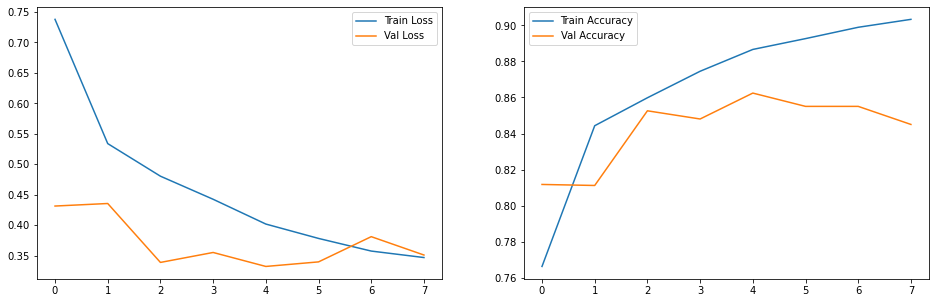

In [57]:
plot_nn_history(history)

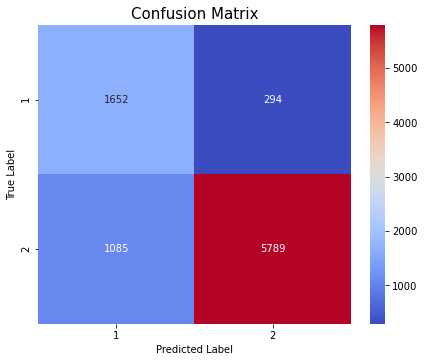

Accuracy: 0.8437


In [58]:
nn_metrics(model, test_padded_sequence, y_test['pn_2'], 2)

### Reviews with Rating of 3 Excluded

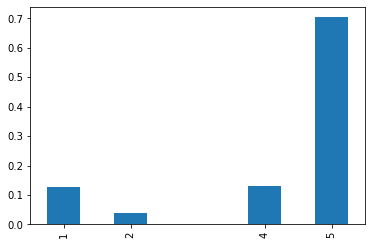

In [59]:
nn_df_2 = nn_df[nn_df['score'] != 3].copy()

nn_df_2['score'].value_counts(normalize=True).plot(kind='bar');

In [60]:
X = nn_df_2['content'].values
y = nn_df_2[['score']].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 11, stratify = y)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((24744,), (24744, 1), (8248,), (8248, 1))

In [61]:
y_train.value_counts(normalize = True)

score
5        0.703403
4        0.129890
1        0.126980
2        0.039727
dtype: float64

In [62]:
y_test.value_counts(normalize = True)

score
5        0.703443
4        0.129971
1        0.126940
2        0.039646
dtype: float64

In [63]:
vocab_size = 7000

tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)

max_len = 125

train_padded_sequence = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = max_len)
test_padded_sequence = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen = max_len)

In [64]:
print(X_train[0])
print(train_padded_sequence[0])

The game is one of the best ever. Good graphics and the game macanics are also good. The only problem is that you get a little bored fighting the same enemies over and over. In simple words make new enemies with special powers.
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    1    2
    5   56   11    1   25   55   18   30    4    1    2 5644   27   91
   18    1   53  106    5   20   14   47    8  207  701  442    1  242
  619  224    4  224   16  754  667   88  134  619   26 1548 1827]


In [65]:
y_train = y_train.copy()
y_test = y_test.copy()

In [66]:
def positive_negative(score):
    if score <= 3:
        return 1
    if score > 3:
        return 2
    
y_train['pn'] = y_train['score'].apply(lambda x: positive_negative(x))
y_test['pn'] = y_test['score'].apply(lambda x: positive_negative(x))

enc = OneHotEncoder()
scores_cat = enc.fit_transform(y_train[['pn']]).toarray()

classweight = find_class_weight(y_train[['pn']])

In [67]:
embedding_vector_length = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_len))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

earlystop_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

history = model.fit(train_padded_sequence, scores_cat, validation_split=0.2, 
                    epochs=10, batch_size=32, callbacks=[earlystop_callback], class_weight = classweight)

Epoch 1/10
619/619 [==============================] - 48s 77ms/step - loss: 0.7797 - accuracy: 0.7776 - val_loss: 0.2974 - val_accuracy: 0.8767
Epoch 2/10
619/619 [==============================] - 47s 76ms/step - loss: 0.5208 - accuracy: 0.8613 - val_loss: 0.2867 - val_accuracy: 0.8907
Epoch 3/10
619/619 [==============================] - 47s 76ms/step - loss: 0.4453 - accuracy: 0.8814 - val_loss: 0.2859 - val_accuracy: 0.8739
Epoch 4/10
619/619 [==============================] - 47s 76ms/step - loss: 0.3929 - accuracy: 0.8997 - val_loss: 0.2670 - val_accuracy: 0.8909
Epoch 5/10
619/619 [==============================] - 47s 76ms/step - loss: 0.3650 - accuracy: 0.9060 - val_loss: 0.3158 - val_accuracy: 0.8769
Epoch 6/10
619/619 [==============================] - 47s 76ms/step - loss: 0.3394 - accuracy: 0.9131 - val_loss: 0.2882 - val_accuracy: 0.8990
Epoch 7/10
619/619 [==============================] - 47s 76ms/step - loss: 0.3135 - accuracy: 0.9180 - val_loss: 0.2597 - val_accuracy:

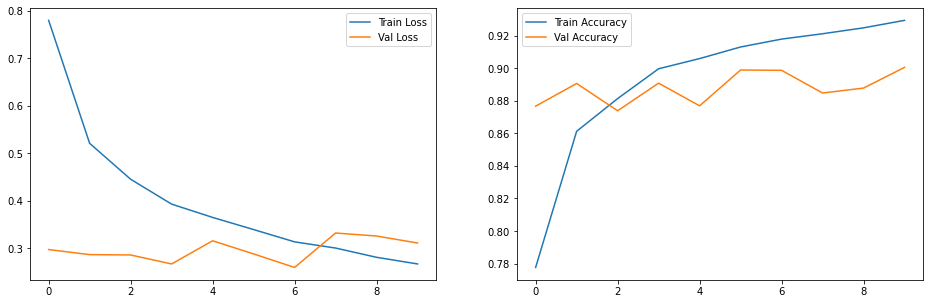

In [68]:
plot_nn_history(history)

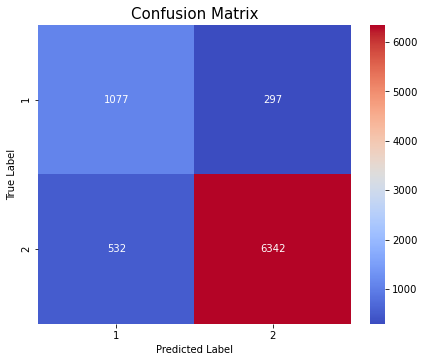

Accuracy: 0.8995


In [69]:
nn_metrics(model, test_padded_sequence, y_test['pn'], 2)

The models with two classes performs better than the models with 3 classes. This is understandable as the neutral class in the 3 classes model has much fewer records compared to the majority class (the positive class)

Within the models with two classes, the model that excludes reviews with rating = 3 performs the best. This could be because the reviews with ratings of 3 are likely to contain reviews with both positive and negative sentiment, resulting in noise, hence, excluding this class will result in a more accurate model.

Hence, further modeling will be carried out using 2 models, with reviews with ratings of 3 excluded.

I will continue to optimize the LSTM model, however, as this notebook is already very long, I will continue in the next notebook (3. Sentiment Analysis & Classification (Part 2)).